In [1]:
%load_ext autotime

time: 144 µs (started: 2022-01-21 10:46:54 +01:00)


In [2]:
from gscore.parsers import sqmass
from gscore.parsers.osw import OSWFile
from gscore.parsers import queries

time: 1.01 s (started: 2022-01-21 10:46:55 +01:00)


In [3]:
sqmass_file_path = "/home/aaron/projects/ghost/data/spike_in/chromatograms/AAS_P2009_167.sqMass"
osw_file_path = "/home/aaron/projects/ghost/data/spike_in/openswath/AAS_P2009_167.osw"

time: 308 µs (started: 2022-01-21 10:46:56 +01:00)


In [4]:
with sqmass.SqMassFile(sqmass_file_path) as sqmass_file:

    chromatograms = sqmass_file.parse()

time: 46.8 s (started: 2022-01-21 10:46:56 +01:00)


In [5]:
with OSWFile(osw_file_path) as osw_file:

    precursors = osw_file.parse_to_precursors(
        query=queries.SelectPeakGroups.FETCH_CHROMATOGRAM_TRAINING_RECORDS
    )

Cleaning unused score columns.
time: 15 s (started: 2022-01-21 10:47:43 +01:00)


In [6]:
precursors.set_chromatograms(chromatograms)

time: 1min 1s (started: 2022-01-21 10:47:58 +01:00)


In [7]:
from gscore.chromatograms import Chromatogram
import numpy as np

chrom_lengths = []
labels = []
probabilities = []

for precursor in precursors:

    precursor.peakgroups.sort(key=lambda x: x.scores["PROBABILITY"], reverse=True)

    peakgroup = precursor.peakgroups[0]

    if peakgroup.chromatograms:

        chrom_lengths.append(
            peakgroup.get_chromatogram_intensity_arrays(interpolated=False, scaled=False).shape[1]
        )

        probabilities.append(peakgroup.scores["PROBABILITY"])

        labels.append(peakgroup.target)

        interpolated_chroms = peakgroup.get_chromatogram_intensity_arrays(
            scaled=False, interpolated=True, use_relative_intensities=True
        )


time: 25 s (started: 2022-01-21 10:49:00 +01:00)


In [8]:
import seaborn as sns
import pandas as pd

time: 147 ms (started: 2022-01-21 10:49:25 +01:00)


In [9]:
import matplotlib.pyplot as plt

time: 208 µs (started: 2022-01-21 10:49:25 +01:00)


In [10]:
chrom_lengths_df = pd.DataFrame(
    {
        "chrom_length": chrom_lengths,
        "label": labels,
        "probability": probabilities,
        "logits": np.log(np.array(probabilities) / (1 - np.array(probabilities)))
    }
)

time: 39.6 ms (started: 2022-01-21 10:49:25 +01:00)


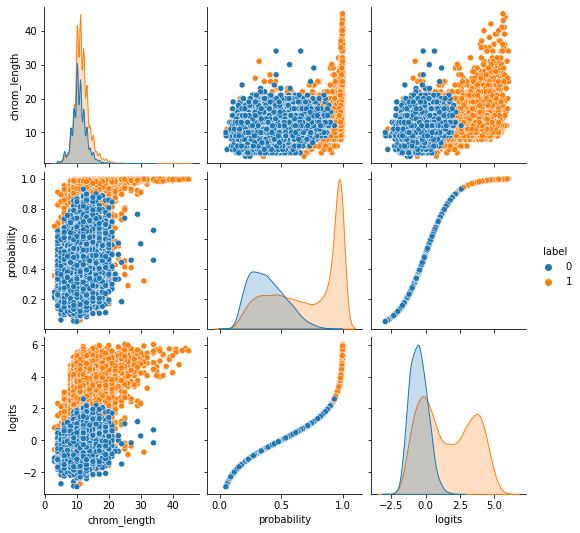

time: 13 s (started: 2022-01-21 10:49:25 +01:00)


In [11]:
sns.pairplot(data=chrom_lengths_df, hue="label")

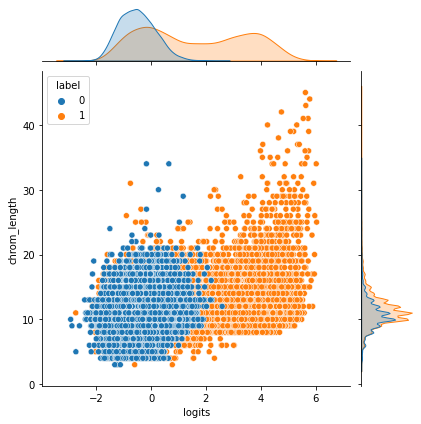

time: 1.76 s (started: 2022-01-21 10:49:38 +01:00)


In [12]:
sns.jointplot(
    data=chrom_lengths_df,
    x="logits",
    y="chrom_length",
    hue="label"
)

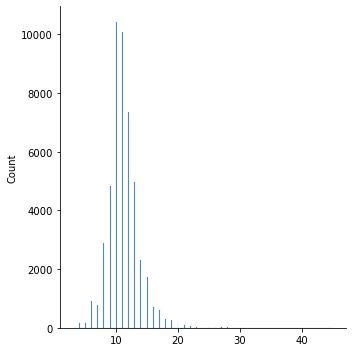

time: 574 ms (started: 2022-01-21 10:50:17 +01:00)


In [14]:
sns.displot(chrom_lengths)

# Bias towards chromatogram length

In order to mediate bias of longer chromatograms, chromatograms are interpolated to a uniform length, and relative intensities are calculated for the peakgroup chromatogram

In [15]:
no_interpolation_test_chroms = peakgroup.get_chromatogram_intensity_arrays(scaled=False, interpolated=False)

time: 315 µs (started: 2022-01-21 10:50:32 +01:00)


In [16]:
no_interpolated_chroms = dict()

for i in range(no_interpolation_test_chroms.T.shape[1]):

    no_interpolated_chroms[i] = no_interpolation_test_chroms.T[:, i]

no_interpolated_chroms["rt"] = peakgroup.get_chromatogram_rt_array(interpolated=False)

no_interpolation_df = pd.DataFrame(
    no_interpolated_chroms
)
no_interpolation_df

,0,1,2,3,4,5,rt
0,0.000000,0.000000,26887.764640,46257.131001,0.0,0.000000,6213.8
1,8555.710358,0.000000,42549.421511,148512.322491,0.0,0.000000,6217.3
2,6425.417595,0.000000,23209.689036,286510.370980,0.0,7509.264576,6220.7
3,4421.662275,0.000000,19931.151605,357675.617799,0.0,0.000000,6224.2
4,0.000000,0.000000,10546.332249,390513.767732,0.0,0.000000,6227.6
5,0.000000,0.000000,13868.453994,229685.005428,0.0,11703.103727,6231.1
6,0.000000,0.000000,8185.057388,107196.981481,0.0,20975.045259,6234.5
7,0.000000,4245.248347,0.000000,44975.378547,0.0,41681.000642,6238.0
8,5165.322201,0.000000,8104.980990,8604.266612,0.0,22737.576851,6241.4
9,4634.650824,0.000000,5892.940519,0.000000,0.0,16184.695169,6244.9


time: 8.78 ms (started: 2022-01-21 10:50:33 +01:00)


In [17]:
temp_inter_chroms = dict()

for i in range(interpolated_chroms.T.shape[1]):

    temp_inter_chroms[i] = interpolated_chroms.T[:, i]

temp_inter_chroms["rt"] = peakgroup.get_chromatogram_rt_array(interpolated=True)

time: 471 µs (started: 2022-01-21 10:50:36 +01:00)


In [18]:
interpolation_df = pd.DataFrame(
    temp_inter_chroms
)
interpolation_df

,0,1,2,3,4,5,rt
0,0.000000,0.000000,0.070316,0.120970,0.0,0.000000,6213.800000
1,0.008284,0.000000,0.085480,0.219977,0.0,0.000000,6215.095833
2,0.016568,0.000000,0.100644,0.318984,0.0,0.000000,6216.391667
3,0.021740,0.000000,0.105510,0.429515,0.0,0.002238,6217.687500
4,0.019616,0.000000,0.086233,0.567059,0.0,0.009723,6218.983333
5,0.017493,0.000000,0.066957,0.704604,0.0,0.017207,6220.279167
6,0.015494,0.000000,0.058554,0.795800,0.0,0.014728,6221.575000
7,0.013553,0.000000,0.055379,0.864704,0.0,0.007458,6222.870833
8,0.011613,0.000000,0.052205,0.933609,0.0,0.000187,6224.166667
9,0.007270,0.000000,0.043010,0.967270,0.0,0.000000,6225.462500


time: 10.3 ms (started: 2022-01-21 10:50:39 +01:00)


In [19]:
melted_chrom_df = interpolation_df.melt(id_vars=['rt'])
melted_chrom_df

,rt,variable,value
0,6213.800000,0,0.000000
1,6215.095833,0,0.008284
2,6216.391667,0,0.016568
3,6217.687500,0,0.021740
4,6218.983333,0,0.019616
...,...,...,...
145,6239.716667,5,0.083990
146,6241.012500,5,0.065109
147,6242.308333,5,0.055015
148,6243.604167,5,0.048670


time: 8.89 ms (started: 2022-01-21 10:50:46 +01:00)


<AxesSubplot:xlabel='rt', ylabel='value'>

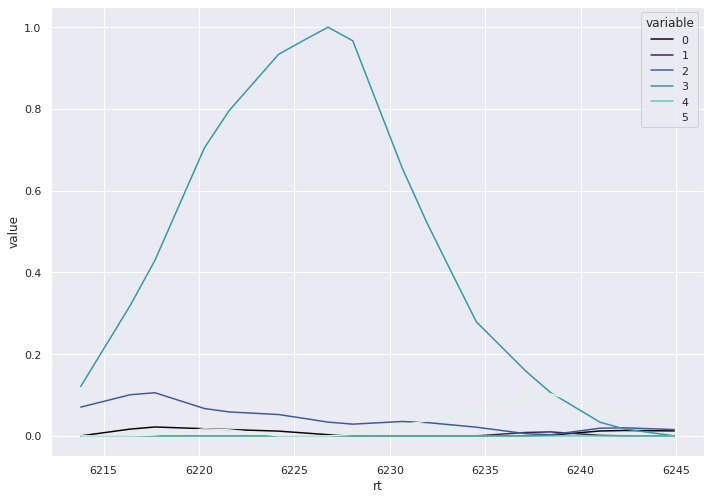

time: 212 ms (started: 2022-01-21 10:50:47 +01:00)


In [20]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot(data=melted_chrom_df, x="rt", y="value", hue="variable", palette="mako")

In [21]:
no_interpolation_melted = no_interpolation_df.melt(id_vars=['rt'])
no_interpolation_melted

,rt,variable,value
0,6213.8,0,0.000000
1,6217.3,0,8555.710358
2,6220.7,0,6425.417595
3,6224.2,0,4421.662275
4,6227.6,0,0.000000
5,6231.1,0,0.000000
6,6234.5,0,0.000000
7,6238.0,0,0.000000
8,6241.4,0,5165.322201
9,6244.9,0,4634.650824


time: 10.4 ms (started: 2022-01-21 10:51:03 +01:00)


<AxesSubplot:xlabel='rt', ylabel='value'>

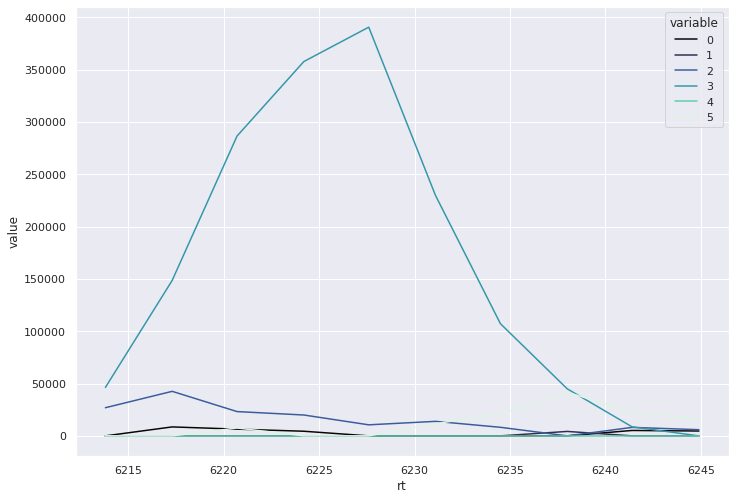

time: 276 ms (started: 2022-01-21 10:51:04 +01:00)


In [22]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot(data=no_interpolation_melted, x="rt", y="value", hue="variable", palette="mako")